In [1]:
import math
import os
import random

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
from accelerate import Accelerator
from datasets import load_dataset
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    UNet2DConditionModel,
)
from diffusers.optimization import get_scheduler
from PIL import Image, ImageDraw, ImageFont
from tqdm.auto import tqdm
from transformers import (
    AutoProcessor,
    BlipForConditionalGeneration,
    CLIPTextModel,
    CLIPTokenizer,
    default_data_collator,
    Trainer,
    TrainingArguments,
)
from ultralytics import YOLO

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
2025-06-20 08:44:06.484874: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-20 08:44:06.550870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0

In [2]:
from huggingface_hub import notebook_login
notebook_login()

# 1. EDA

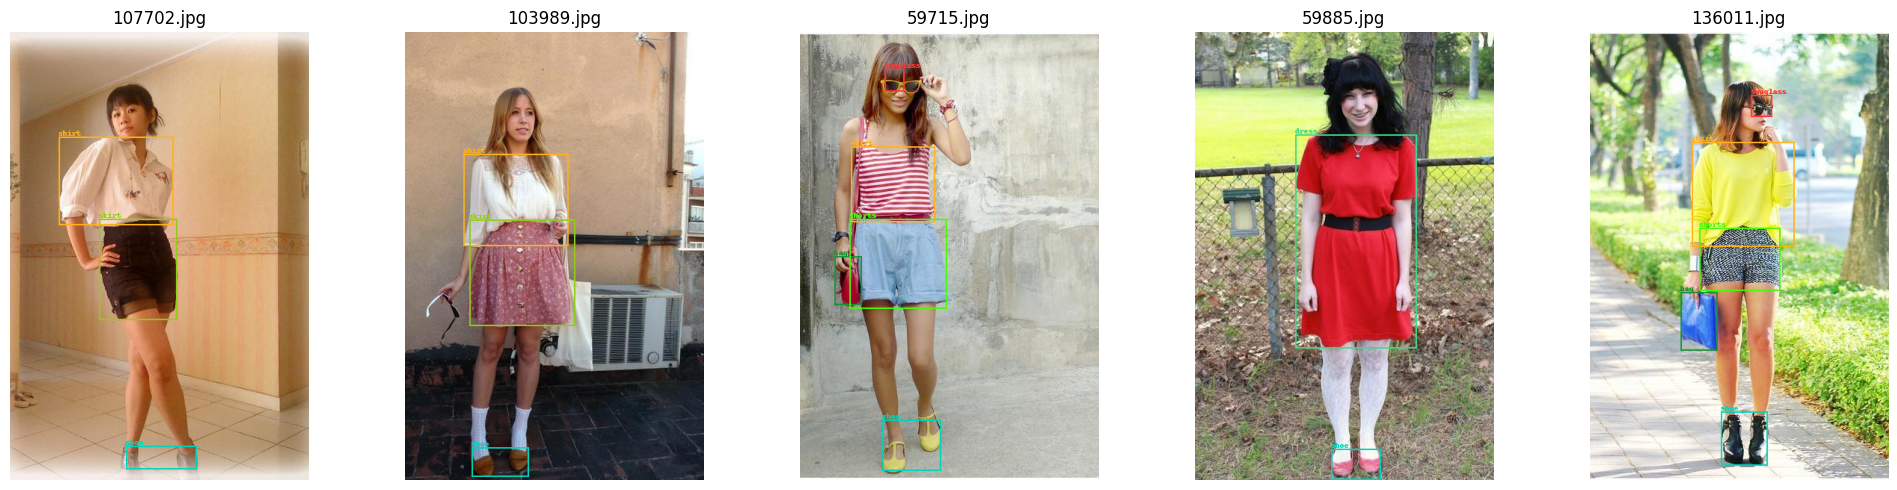

In [3]:

base_path = 'transforming-fashion-2025/Dataset'
image_dir = os.path.join(base_path, 'Train', 'images')
label_dir = os.path.join(base_path, 'Train', 'labels')

class_names = {
    0: 'sunglass', 1: 'hat', 2: 'jacket', 3: 'shirt', 4: 'pants',
    5: 'shorts', 6: 'skirt', 7: 'dress', 8: 'bag', 9: 'shoe'
}

colors = ['#FF3838', '#FF9D97', '#FF701F', '#FFB21D', '#CFD231', '#48F90A', '#92CC17', '#3DDB86', '#1A9334', '#00D4BB']

all_images = os.listdir(image_dir)
selected_images = random.sample(all_images, 5)

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, image_name in enumerate(selected_images):
    image_path = os.path.join(image_dir, image_name)
    
    label_name = os.path.splitext(image_name)[0] + '.txt'
    label_path = os.path.join(label_dir, label_name)

    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    img_width, img_height = img.size

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            
            class_id = int(parts[0])
            center_x_norm = float(parts[1])
            center_y_norm = float(parts[2])
            width_norm = float(parts[3])
            height_norm = float(parts[4])

            center_x = center_x_norm * img_width
            center_y = center_y_norm * img_height
            box_width = width_norm * img_width
            box_height = height_norm * img_height

            x_min = center_x - (box_width / 2)
            y_min = center_y - (box_height / 2)
            x_max = center_x + (box_width / 2)
            y_max = center_y + (box_height / 2)
            
            draw.rectangle([x_min, y_min, x_max, y_max], outline=colors[class_id], width=2)
            
            label_text = class_names[class_id]
            draw.text((x_min, y_min - 10), label_text, fill=colors[class_id])

    axs[i].imshow(img)
    axs[i].set_title(image_name)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# 2. Objectdetectie

## 2.1 Inleiding
Voor deze opdracht wordt YOLOv8 (You Only Look Once, versie 8) gebruikt. Dit is een
state-of-the-art, real-time objectdetectiemodel dat bekend staat om zijn snelheid en
hoge nauwkeurigheid. We gebruiken een voorgetraind model ('yolov8n.pt'), dat al
getraind is op de grote COCO-dataset. Door dit model te 'fine-tunen' op onze
fashion-dataset, kan het met relatief weinig trainingstijd leren om de specifieke
kledingstukken te herkennen.

## 2.2 Hoe het model voorspellingen doet
Het YOLOv8-model doet voorspellingen in één enkele pass door het neurale netwerk,
vandaar de naam 'You Only Look Once'. Het proces kan als volgt worden samengevat
(Jocher et al., 2023):
1. Input & Backbone: De input-afbeelding wordt eerst door een 'backbone'-netwerk
   (CSPDarknet53) gestuurd. Deze backbone extraheert op verschillende schalen
   'feature maps'. Dit zijn representaties van de afbeelding waarin belangrijke
   visuele kenmerken (zoals randen, texturen, vormen) zijn vastgelegd.
2. Neck: De feature maps van de backbone gaan vervolgens naar de 'neck'
   (een PANet-structuur). De neck combineert de feature maps van verschillende
   schalen. Dit helpt het model om zowel kleine als grote objecten goed te
   detecteren.
3. Head (Detectie): De 'head' van het model is verantwoordelijk voor de uiteindelijke
   voorspellingen. YOLOv8 is 'anchor-free'. In plaats van vooraf gedefinieerde
   'anchor boxes' te gebruiken, voorspelt de head direct het middelpunt, de
   hoogte en breedte van een object. Voor elke locatie in de feature map voorspelt
   de head:
   - Een class-score voor elk van de 10 klassen (shirt, tas, etc.).
   - De coördinaten en afmetingen van de bounding box.
4. Output: Na een non-maximum suppression (NMS) stap, die overlappende bounding
   boxes voor hetzelfde object wegfiltert, blijven de definitieve detecties over.

## 2.3 Hoe de afbeeldingen worden voorbewerkt (Preprocessing & Augmentation)
De `ultralytics` library handelt de voorbewerking en data-augmentatie automatisch
af tijdens de training. Dit is een cruciaal proces voor het behalen van goede
resultaten en het voorkomen van overfitting.

Voorbewerking:
- Resizing: Alle afbeeldingen worden naar een vaste grootte geschaald,
  gespecificeerd door de hyperparameter `imgsz` (in ons geval 640x640 pixels).
- Normalisatie: De pixelwaarden (0-255) worden genormaliseerd naar een schaal
  van 0.0 tot 1.0. Dit is een standaardprocedure die de training stabiliseert.

Data Augmentatie:
Tijdens de training worden willekeurige aanpassingen op de afbeeldingen toegepast.
Hierdoor 'ziet' het model elke afbeelding steeds in een iets andere vorm, wat helpt
om een robuuster model te trainen (Jocher et al., 2023). Standaard past YOLOv8 o.a.
de volgende augmentaties toe:
- Kleurruimte aanpassingen (Hue, Saturation, Value).
- Horizontaal spiegelen (`fliplr`).
- Schalen en transleren.

## 2.4 Feature Engineering
Bij het gebruik van diepe neurale netwerken zoals YOLOv8 is traditionele, handmatige
'feature engineering' niet van toepassing. De kracht van deep learning modellen ligt
juist in het feit dat ze hiërarchische features zelfstandig leren uit de data
(LeCun et al., 2015). De convolutionele lagen in de 'backbone' functioneren als
automatische feature extractors:
- De eerste lagen leren simpele features zoals randen en kleuren.
- Diepere lagen combineren deze om complexere patronen te herkennen, zoals
  stoffen, knopen, of de vorm van een broekspijp.
Onze taak is dus niet het ontwerpen van features, maar het correct aanleveren van
gelabelde data en het juist configureren van het trainingsproces.

## 2.5 Onderbouwing van Hyperparameters, Optimizer en Epochs 
De keuzes hieronder zijn een balans tussen prestaties en trainingstijd.
- `data`: 'data.yaml'. Dit is het configuratiebestand
  dat we eerder hebben gemaakt. Het vertelt het model waar de data staat en wat
  de klassen zijn.
- `epochs`: 100. Een epoch is één volledige doorgang over de gehele trainingsdataset.
  100 epochs is een solide startpunt. Door 'patience' te gebruiken, zal de
  training eerder stoppen als het model niet meer verbetert, wat overbodige
  trainingstijd voorkomt.
- `patience`: 20. Dit is voor 'early stopping'. Als de mAP@0.5 score (de primaire
  evaluatiemetriek) op de validatieset 20 epochs lang niet verbetert, wordt de
  training automatisch gestopt. Dit voorkomt overfitting en slaat het best
  presterende model op.
- `batch`: 16. Dit is het aantal afbeeldingen dat tegelijk door het netwerk wordt
  verwerkt. 16 is een gangbare waarde die vaak goed past op moderne GPU's. Een
  grotere batch size kan de training versnellen, maar vereist meer VRAM.
- `imgsz`: 640. De invoerafbeeldingen worden naar 640x640 pixels geschaald. Dit
  is een standaard en effectieve resolutie voor YOLO-modellen.
- `optimizer`: 'AdamW'. Hoewel de `ultralytics` library zelf de optimizer kiest
  (standaard 'AdamW'), is dit een uitstekende keuze. AdamW (Adaptive Moment
  Estimation with Weight Decay) is een variant van de populaire Adam-optimizer die
  'weight decay' op een effectievere manier toepast, wat vaak leidt tot betere
  generalisatie en dus een beter presterend model (Loshchilov & Hutter, 2019).

## 2.6 De Loss Functie 
De totale loss van het model is een som van drie componenten. De loss-functie
berekent het verschil tussen de voorspelling van het model en de ware labels, en
stuurt het leerproces door dit verschil te minimaliseren (Jocher et al., 2023).
1. Box Loss (Regressie Loss): Deze berekent de fout in de locatie en grootte van
   de voorspelde bounding box. YOLOv8 gebruikt 'Complete IoU' (CIoU) loss. Deze
   houdt niet alleen rekening met de overlap (Intersection over Union), maar ook
   met de afstand tussen de middelpunten en het verschil in beeldverhouding.
   Daarnaast wordt 'Distribution Focal Loss' (DFL) gebruikt om de continue
   locaties van de box te leren als een discrete distributie, wat de precisie
   verhoogt.
2. Class Loss (Classificatie Loss): Deze berekent hoe goed het model de juiste
   klasse voorspelt (bv. 'shirt' vs 'broek'). Hiervoor wordt 'Binary Cross-Entropy'
   (BCE) gebruikt. Deze meet de fout voor elke klasse afzonderlijk.
De gewogen som van deze losses vormt de uiteindelijke loss-waarde die het model
tijdens de training probeert te minimaliseren.

In [4]:
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    for device in range(torch.cuda.device_count()):
        print(f"CUDA Device Name {device + 1}: {torch.cuda.get_device_name(device)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

CUDA Available: True
CUDA Device Name 1: NVIDIA A40
Number of GPUs: 1


In [ ]:
#model = YOLO('yolov8n.pt')
#model = YOLO('yolov8s.pt')
#model = YOLO('yolov8m.pt')
#model = YOLO('yolov8l.pt')
model = YOLO('yolov8x.pt')

results = model.train(
    data='data.yaml',
    epochs=100,
    patience=20,
    batch=16,
    imgsz=640,
    optimizer='AdamW',
    workers=8,
    device=0
)

100%|██████████| 83.7M/83.7M [00:00<00:00, 112MB/s] 


Ultralytics 8.3.156 🚀 Python-3.10.12 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 15955MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train14, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrain

train: Scanning /workspace/DeepLearning/Opdracht 3/transforming-fashion-2025/Dataset/Train/labels.cache... 2049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2049/2049 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1158.6±769.2 MB/s, size: 37.6 KB)


val: Scanning /workspace/DeepLearning/Opdracht 3/transforming-fashion-2025/Dataset/Val/labels.cache... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<?, ?it/s]


Plotting labels to runs/detect/train14/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train14
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      9.81G      1.806      2.653      1.898          5        640: 100%|██████████| 129/129 [00:27<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.25it/s]

                   all         96        388     0.0471      0.289     0.0467     0.0179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.74G      1.719       2.05      1.861         13        640: 100%|██████████| 129/129 [00:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.50it/s]

                   all         96        388      0.351      0.124      0.132      0.059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      9.54G      1.613      1.846       1.79          4        640: 100%|██████████| 129/129 [00:26<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]

                   all         96        388      0.315      0.308      0.275      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.86G      1.569      1.731      1.751          5        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]

                   all         96        388      0.645      0.502      0.556      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.57G      1.506      1.642      1.707          4        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]

                   all         96        388      0.485      0.604      0.572      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.59G      1.458      1.551      1.665          7        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.59it/s]

                   all         96        388      0.676      0.579      0.655       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.72G      1.441      1.498      1.643          5        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.38it/s]

                   all         96        388      0.529      0.628      0.634      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.88G      1.423      1.461      1.636          5        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.50it/s]

                   all         96        388        0.6      0.561      0.656      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.56G      1.397      1.391      1.603          4        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.54it/s]

                   all         96        388      0.671      0.639      0.685      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.87G      1.386      1.393       1.61         13        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]

                   all         96        388      0.668      0.628      0.696      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.72G      1.353      1.338      1.581          6        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.50it/s]

                   all         96        388       0.59      0.698      0.698      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.87G      1.334      1.296       1.57          4        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.66it/s]

                   all         96        388      0.642      0.696      0.698      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.57G      1.331      1.289      1.571         15        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.54it/s]

                   all         96        388      0.544      0.721      0.707       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.59G       1.29      1.245      1.532         15        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.59it/s]

                   all         96        388      0.614      0.739      0.753       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.69G      1.292      1.223      1.531          7        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.54it/s]

                   all         96        388      0.741      0.673      0.747      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.88G      1.286      1.211      1.531         11        640: 100%|██████████| 129/129 [00:26<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.63it/s]

                   all         96        388      0.646      0.733      0.767      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.59G       1.28      1.175      1.529          9        640: 100%|██████████| 129/129 [00:26<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.59it/s]

                   all         96        388      0.722      0.637      0.736      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.58G       1.26      1.156      1.498         14        640: 100%|██████████| 129/129 [00:26<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.59it/s]

                   all         96        388      0.713      0.706      0.781      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.71G      1.256      1.146      1.502         10        640: 100%|██████████| 129/129 [00:26<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.49it/s]

                   all         96        388      0.668      0.738      0.782      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.88G      1.234      1.119      1.484         11        640: 100%|██████████| 129/129 [00:26<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.59it/s]

                   all         96        388      0.737      0.708       0.79      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.56G      1.231       1.12       1.48          5        640: 100%|██████████| 129/129 [00:26<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]

                   all         96        388      0.613      0.759      0.758      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.89G      1.215      1.088      1.471         11        640: 100%|██████████| 129/129 [00:26<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]

                   all         96        388      0.728      0.765      0.816      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.72G      1.202      1.055      1.461          4        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.49it/s]

                   all         96        388      0.781      0.663      0.789      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.88G      1.196      1.051      1.461          3        640: 100%|██████████| 129/129 [00:26<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]

                   all         96        388      0.759      0.731      0.804      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      9.59G      1.188      1.037      1.458          9        640: 100%|██████████| 129/129 [00:26<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.63it/s]

                   all         96        388      0.712      0.743      0.792      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.86G      1.191      1.045      1.457          7        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.63it/s]

                   all         96        388      0.801      0.707      0.778       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      9.72G      1.178      1.021      1.451          2        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]

                   all         96        388      0.734      0.762      0.799       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.88G      1.163     0.9947      1.441          6        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]

                   all         96        388       0.77      0.754      0.813      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      9.54G      1.155     0.9881      1.433          5        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.64it/s]

                   all         96        388      0.774      0.743      0.788      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.59G       1.15     0.9842      1.425         15        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.61it/s]

                   all         96        388      0.672      0.774      0.793      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.71G      1.154     0.9762      1.425          4        640: 100%|██████████| 129/129 [00:26<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.49it/s]

                   all         96        388      0.804      0.771      0.813      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       9.9G      1.135      0.943      1.412         10        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.61it/s]

                   all         96        388      0.747      0.754      0.804      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      9.57G      1.135     0.9459      1.409          6        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.61it/s]

                   all         96        388      0.671      0.789      0.796      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      9.59G      1.124     0.9402      1.409          5        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]

                   all         96        388      0.802      0.787      0.835      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       9.7G       1.13     0.9291      1.402         13        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]

                   all         96        388      0.675       0.82       0.81      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      9.88G      1.116     0.9396        1.4          2        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.62it/s]

                   all         96        388      0.742      0.786      0.818      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      9.58G      1.085     0.8975      1.379          8        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.67it/s]

                   all         96        388      0.785      0.737      0.811      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      9.86G      1.102     0.8969       1.38         12        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.49it/s]

                   all         96        388      0.826      0.738      0.809      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.72G      1.101     0.8839      1.383         12        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.46it/s]

                   all         96        388      0.783      0.753      0.834      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      9.89G      1.077     0.8638      1.369          8        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.59it/s]

                   all         96        388      0.777      0.761      0.823      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      9.54G      1.071     0.8669      1.366         10        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.66it/s]

                   all         96        388      0.718      0.785      0.789      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.58G      1.059     0.8497      1.352          5        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.62it/s]

                   all         96        388      0.729      0.801      0.811      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      9.72G      1.047     0.8421       1.35          9        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.51it/s]

                   all         96        388      0.735      0.783       0.79      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      9.86G      1.053     0.8311      1.353          4        640: 100%|██████████| 129/129 [00:26<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.62it/s]

                   all         96        388      0.744      0.765      0.817      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      9.56G      1.044     0.8232      1.336         10        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.62it/s]

                   all         96        388       0.75      0.766      0.806      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      9.59G       1.04      0.818      1.333          6        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.63it/s]

                   all         96        388       0.73      0.769      0.801      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.72G      1.027     0.8098      1.335          6        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.49it/s]

                   all         96        388      0.683      0.797      0.807      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      9.89G      1.024     0.8048      1.333          6        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.68it/s]

                   all         96        388      0.775      0.805      0.836      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      9.58G      1.008     0.7861       1.32          7        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]

                   all         96        388      0.702      0.788      0.809       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      9.59G      1.006     0.7865      1.311         10        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]

                   all         96        388       0.74       0.79      0.816      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      9.77G      1.007     0.7718      1.326         11        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.55it/s]

                   all         96        388       0.69      0.789      0.802      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.87G     0.9903     0.7621      1.306          4        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.67it/s]

                   all         96        388      0.759      0.794      0.837      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.58G     0.9779     0.7545      1.298          6        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.64it/s]

                   all         96        388      0.726      0.813      0.818      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      9.89G     0.9811     0.7421      1.296         13        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.68it/s]

                   all         96        388      0.809       0.77      0.826      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.72G     0.9665     0.7293      1.286         11        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.58it/s]

                   all         96        388      0.753      0.785      0.815      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      9.88G     0.9586     0.7251      1.279         14        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.61it/s]

                   all         96        388      0.778      0.765      0.817      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      9.59G     0.9427     0.7097      1.274          9        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.63it/s]

                   all         96        388      0.769      0.798      0.836      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      9.55G     0.9535     0.7194      1.277          4        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]

                   all         96        388      0.777      0.752      0.802      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      9.71G     0.9393     0.7075      1.275          3        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.52it/s]

                   all         96        388      0.756       0.77      0.805      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      9.89G     0.9327     0.6957      1.258          5        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]

                   all         96        388      0.735      0.811      0.817      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      9.58G     0.9221      0.692      1.262          4        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.68it/s]

                   all         96        388      0.752      0.785      0.803      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      9.57G     0.9088     0.6734      1.247          3        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]

                   all         96        388      0.776      0.791        0.8       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      9.69G     0.9039     0.6688      1.247          3        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]

                   all         96        388      0.761      0.787      0.816      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      9.87G     0.8928     0.6639      1.236          5        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.67it/s]

                   all         96        388       0.76      0.796      0.796      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      9.59G     0.8876     0.6514      1.231         10        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]

                   all         96        388      0.748      0.783      0.803      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      9.87G     0.8967     0.6591      1.247          4        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]

                   all         96        388      0.711      0.825      0.798      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      9.75G     0.8815     0.6481      1.227          2        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.54it/s]

                   all         96        388      0.724      0.804      0.793       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      9.87G     0.8636     0.6321      1.213          6        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.62it/s]

                   all         96        388       0.77      0.784      0.804      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      9.56G     0.8606     0.6168      1.206          6        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.64it/s]

                   all         96        388       0.78      0.757      0.801      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      9.88G     0.8624     0.6257      1.217         13        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.63it/s]

                   all         96        388      0.732      0.806      0.798      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       9.7G     0.8457     0.6071      1.206          6        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.58it/s]

                   all         96        388      0.783      0.774      0.809      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       9.9G      0.848     0.6142      1.206          4        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.63it/s]

                   all         96        388      0.775      0.761      0.795      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      9.57G     0.8341     0.5932      1.182          6        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.63it/s]

                   all         96        388      0.722      0.817      0.815      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      9.56G     0.8217     0.5911      1.185          7        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.67it/s]

                   all         96        388      0.737      0.814      0.819      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      9.72G     0.8198     0.5926      1.186         15        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.41it/s]

                   all         96        388      0.725      0.767      0.799      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      9.87G     0.8097     0.5803       1.17          7        640: 100%|██████████| 129/129 [00:26<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.39it/s]

                   all         96        388      0.752      0.775        0.8       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      9.57G      0.801       0.57      1.165          5        640: 100%|██████████| 129/129 [00:26<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]

                   all         96        388      0.718      0.792      0.792      0.535
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 57, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



77 epochs completed in 0.585 hours.
Optimizer stripped from runs/detect/train14/weights/last.pt, 87.6MB
Optimizer stripped from runs/detect/train14/weights/best.pt, 87.6MB

Validating runs/detect/train14/weights/best.pt...
Ultralytics 8.3.156 🚀 Python-3.10.12 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 15955MiB)
Model summary (fused): 112 layers, 43,614,318 parameters, 0 gradients, 164.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.01it/s]


                   all         96        388      0.769      0.797      0.836      0.566
              sunglass         24         24      0.737      0.417      0.553      0.201
                   hat         11         11       0.61       0.57      0.671      0.476
                jacket         21         21       0.71      0.933      0.913      0.772
                 shirt         77         78      0.809      0.846      0.899      0.597
                 pants         17         17      0.962          1      0.995       0.79
                shorts         26         26      0.839      0.885      0.903      0.501
                 skirt         35         35      0.801      0.943      0.908      0.717
                 dress         19         19      0.723      0.826      0.878      0.638
                   bag         64         64      0.683      0.703      0.759      0.447
                  shoe         93         93      0.816      0.849      0.879       0.52
Speed: 0.1ms preproce

In [ ]:
run = 15
model_path = f'runs/detect/train{run}/weights/best.pt' 

model = YOLO(model_path)

test_image_dir = os.path.join('transforming-fashion-2025', 'Dataset', 'Test', 'images')

test_image_files = os.listdir(test_image_dir)

submission_ids = []
submission_predictions = []

for image_name in test_image_files:
    base_name = os.path.splitext(image_name)[0]
    submission_ids.append(base_name)
    image_path = os.path.join(test_image_dir, image_name)
    results = model(image_path, verbose=False) 
    result = results[0]
    prediction_parts = []
    
    for box in result.boxes:
        class_id = int(box.cls)
        confidence = round(float(box.conf), 3)
        xywhn = box.xywhn[0]
        center_x = round(float(xywhn[0]), 3)
        center_y = round(float(xywhn[1]), 3)
        width = round(float(xywhn[2]), 3)
        height = round(float(xywhn[3]), 3)
        prediction_parts.extend([class_id, confidence, center_x, center_y, width, height])
        
    prediction_string = str(prediction_parts)
    
    submission_predictions.append(prediction_string)

submission_dict = {
    'id': submission_ids,
    'predictions': submission_predictions
}

submission_df = pd.DataFrame(submission_dict)

output_filename = f'submission{run}.csv'
submission_df.to_csv(output_filename, index=False)

Voorspellingen voltooid voor 537 afbeeldingen.
Bestand 'submission.csv' succesvol aangemaakt en klaar voor upload naar Kaggle.


# 3. Ondertiteling van afbeeldingen

## 3.1 Hoe het model voorspellingen doet (architectuur)
Het BLIP-model (Bootstrapping Language-Image Pre-training) is een encoder-decoder
model dat visuele informatie (afbeeldingen) koppelt aan tekstuele informatie (taal).
De architectuur bestaat uit drie hoofdcomponenten (Li et al., 2022):
1. Image Encoder: Een Vision Transformer (ViT) die een afbeelding omzet in een reeks
   numerieke 'embeddings'. Deze embeddings representeren de visuele inhoud van de
   afbeelding.
2. Text Encoder/Decoder: Een op de BERT-architectuur gebaseerde Transformer die
   tekst kan verwerken en genereren. Tijdens het genereren van een bijschrift
   functioneert deze als een 'decoder': woord voor woord wordt de beschrijving
   opgebouwd, gebaseerd op de informatie uit de image encoder.
3. Multimodal Encoder: Een extra component die de visuele en tekstuele embeddings
   samenvoegt om een gecombineerde representatie te creëren. Dit helpt het model
   om de relatie tussen wat er te zien is en hoe dat beschreven wordt beter te begrijpen.

Voor het genereren van een voorspelling (een bijschrift), wordt een afbeelding door de
Image Encoder gehaald. De resulterende embedding wordt door de Text Decoder gebruikt
als startpunt om, woord voor woord, de meest waarschijnlijke tekstuele beschrijving
te genereren.

## 3.2 De Lossfunctie en hoe het model traint
Tijdens het fine-tunen op onze H&M-dataset is het doel om het model te leren
bijschriften te genereren die lijken op de voorbeelden in de dataset.
- Lossfunctie: Het model wordt getraind met een 'Language Modeling Loss', wat
  in de praktijk neerkomt op de standaard Cross-Entropy Loss. Het model krijgt
  een afbeelding en het begin van een bijschrift (bv. "A photo of a") en moet
  het volgende woord voorspellen (bv. "shirt"). De loss-functie berekent het
  verschil tussen de voorspelde waarschijnlijkheidsverdeling over alle mogelijke
  volgende woorden en het werkelijke volgende woord in het bijschrift.
- Trainingsproces: De `Trainer`-API van Hugging Face automatiseert dit proces.
  In elke stap wordt een 'batch' van afbeeldingen en bijschriften aan het model
  gegeven. De loss wordt berekend, en via backpropagation worden de gewichten
  van het model lichtjes aangepast om de loss de volgende keer lager te maken.
  Dit proces wordt herhaald voor een vast aantal 'epochs'.

## 3.3 Onderbouwing van Hyperparameters, Optimizer en Epochs
- `output_dir`: De map waarin het getrainde model en de resultaten worden opgeslagen.
- `learning_rate`: 5e-5 (0.00005). Bij fine-tuning van grote, voorgetrainde modellen
  wordt een kleine learning rate gebruikt. Dit zorgt ervoor dat de reeds geleerde
  kennis niet verloren gaat, maar subtiel wordt aangepast aan de nieuwe data.
- `num_train_epochs`: 4. Fine-tuning vereist vaak maar een paar epochs. Na 3-5
  epochs heeft het model de nieuwe data meestal voldoende gezien. Meer epochs kan
  leiden tot overfitting.
- `per_device_train_batch_size` & `per_device_eval_batch_size`: 8. Dit is het aantal
  voorbeelden per batch. Een grotere batch size kan de training stabiliseren, maar
  vereist meer GPU-geheugen. 8 is een veilige keuze.
- `weight_decay`: 0.01. Dit is een regularisatietechniek die helpt overfitting te
  voorkomen door de gewichten van het model klein te houden.
- `optimizer`: AdamW. Voor Transformer-gebaseerde modellen zoals BLIP is AdamW
  (Adam with Decoupled Weight Decay) de de-facto standaard. Het leidt over het
  algemeen tot betere prestaties dan de standaard Adam-optimizer (Loshchilov & Hutter, 2019).
- `save_total_limit`: 2. Bewaart maximaal 2 checkpoints om schijfruimte te besparen.
- `push_to_hub`: True. Slaat het uiteindelijke model op in je Hugging Face-account.

In [3]:
dataset = load_dataset("tomytjandra/h-and-m-fashion-caption-12k", split="train")

dataset = dataset.train_test_split(test_size=0.05)
train_dataset = dataset["train"]
val_dataset = dataset["test"]
model_id = "Salesforce/blip-image-captioning-base"
processor = AutoProcessor.from_pretrained(model_id)

model = BlipForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16)

def preprocess_function(examples):
    inputs = processor(images=examples['image'], text=examples['text'], padding="max_length")
    return inputs

processed_train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
processed_val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=val_dataset.column_names)


training_args = TrainingArguments(
    output_dir="hm-fashion-captioning-blip",
    learning_rate=5e-5,
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=2,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_train_dataset,
    eval_dataset=processed_val_dataset,
    data_collator=default_data_collator
)

print("Starten met fine-tunen van het model...")
trainer.train()
print("Training voltooid.")

trainer.push_to_hub()
print("Model succesvol opgeslagen op de Hugging Face Hub.")


Map:   0%|          | 0/11815 [00:00<?, ? examples/s]

OSError: [Errno 28] No space left on device

# 4. Beeldgeneratie

## 4.1 Modelkeuze en Componenten
- Modelarchitectuur: We gebruiken Stable Diffusion, een Latent Diffusion Model (LDM).
- Voorgetrainde versie: 'runwayml/stable-diffusion-v1-5'.
- Dataset waarop vooraf is getraind: Een subset van de LAION-2B dataset.

Stable Diffusion bestaat uit drie kerncomponenten (Rombach et al., 2022):
1. Text Encoder (CLIP): Een Transformer-model (CLIP ViT-L/14) dat de Engelse
   tekst-input omzet in numerieke 'embeddings'. Deze embeddings vangen de
   betekenis van de tekst en sturen het beeldgeneratieproces.
2. U-Net: Het hart van het model. Dit netwerk opereert niet in de pixel-ruimte,
   maar in een gecomprimeerde 'latente ruimte'. Zijn taak is om, stap voor stap,
   ruis uit een willekeurig beeld te verwijderen, geleid door de text-embeddings.
3. Variational Autoencoder (VAE): Een encoder/decoder die de brug vormt tussen de
   pixel-ruimte en de latente ruimte. De VAE comprimeert de afbeelding naar de
   latente ruimte voor de U-Net en decodeert de 'schone' latente representatie
   terug naar een zichtbare afbeelding van hoge resolutie.

## 4.2 Hoe het model afbeeldingen maakt en welke lossfunctie het gebruikt
- Beeldgeneratie (Diffusion Process): Stable Diffusion genereert beelden via een
  'denoising diffusion' proces. De training leert het U-Net om een voorspelling
  te doen van de ruis die aan een afbeelding is toegevoegd. Bij de daadwerkelijke
  beeldgeneratie start het model met een tensor vol pure willekeurige ruis. In
  een iteratief proces, dat meestal 20-50 stappen duurt, voorspelt en verwijdert
  de U-Net de ruis, waarbij het de text-embedding als gids gebruikt om de ruis
  om te vormen tot een coherente afbeelding die overeenkomt met de tekst.
- Lossfunctie: De U-Net wordt getraind met een verrassend simpele lossfunctie:
  de Mean Squared Error (MSE). In elke trainingsstap wordt een 'schone' afbeelding
  genomen, wordt er een willekeurige hoeveelheid ruis aan toegevoegd, en wordt
  de U-Net gevraagd om de toegevoegde ruis te voorspellen. De loss is de MSE
  tussen de door het model voorspelde ruis en de daadwerkelijke ruis die werd
  toegevoegd.

## 4.3 Trainingparameters
- `resolution`: 512. De afbeeldingen worden geschaald naar 512x512 pixels. Dit is de standaardresolutie waarop dit model is getraind.
- `train_batch_size`: 1. Het fine-tunen van diffusion models kost extreem veel geheugen. Een batch size van 1 is vaak het hoogst haalbare op consumenten-GPU's.
- `gradient_accumulation_steps`: 4. Om de kleine batch size te compenseren, worden de gradiënten van 4 stappen geaccumuleerd voordat de gewichten worden bijgewerkt. Dit simuleert een effectieve batch size van 1 * 4 = 4.
- `num_train_epochs`: 3. Net als bij Opdracht 3, is voor fine-tuning een klein aantal epochs vaak voldoende om het model aan te passen aan de stijl van de nieuwe dataset.
- `learning_rate`: 1e-05 (0.00001). Een zeer lage learning rate is cruciaal om de complexe, reeds geleerde kennis in het model niet te verstoren.
- `lr_scheduler`: 'constant'. Houdt de learning rate gedurende de hele training gelijk, wat voor fine-tuning vaak stabiel werkt.
- `optimizer`: AdamW. Ook hier de standaard en meest robuuste keuze voor Transformer-gebaseerde architecturen (Loshchilov & Hutter, 2019).

In [ ]:
dataset = load_dataset("keremberke/h-and-m-fashion-caption-12k", split="train")

output_dir = "./hm_fashion_diffusion_dataset"
image_dir = os.path.join(output_dir, "images")

os.makedirs(image_dir, exist_ok=True)

with open(os.path.join(output_dir, "metadata.jsonl"), "w") as f:
    for i, example in enumerate(dataset):
        image_filename = f"image_{i}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        
        example["image"].save(image_path)
        
        line = {"file_name": image_filename, "text": example["caption"]}
        f.write(str(line).replace("'", '"') + "\n")

ConnectionError: Couldn't reach 'keremberke/h-and-m-fashion-caption-12k' on the Hub (LocalEntryNotFoundError)

In [ ]:
class TrainingConfig:
    pretrained_model_name = "runwayml/stable-diffusion-v1-5"
    dataset_name = "keremberke/h-and-m-fashion-caption-12k"
    output_dir = "hm-fashion-diffusion-python-script"
    
    image_size = 512
    train_batch_size = 1
    num_train_epochs = 2
    learning_rate = 1e-05
    gradient_accumulation_steps = 4
    
    mixed_precision = "fp16"

config = TrainingConfig()

dataset = load_dataset(config.dataset_name, split="train")

tokenizer = CLIPTokenizer.from_pretrained(config.pretrained_model_name, subfolder="tokenizer")

def tokenize_captions(examples, is_train=True):
    captions = [caption for caption in examples["caption"]]
    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
    return inputs.input_ids

tokenized_ids = tokenize_captions(dataset)

def preprocess_dataset(examples, i):
    examples["input_ids"] = tokenized_ids[i: i + len(examples["image"])]
    images = [image.convert("RGB").resize((config.image_size, config.image_size)) for image in examples["image"]]
    examples["pixel_values"] = images
    return examples
processed_dataset = dataset.map(preprocess_dataset, with_indices=True, batched=True, batch_size=config.train_batch_size)

def collate_fn(examples):
    pixel_values = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in examples["pixel_values"]]).to(torch.float32) / 127.5 - 1.0
    input_ids = torch.stack([torch.tensor(ids) for ids in examples["input_ids"]])
    return {"pixel_values": pixel_values, "input_ids": input_ids}

train_dataloader = torch.utils.data.DataLoader(
    processed_dataset, shuffle=True, collate_fn=collate_fn, batch_size=config.train_batch_size
)

noise_scheduler = DDPMScheduler.from_pretrained(config.pretrained_model_name, subfolder="scheduler")
vae = AutoencoderKL.from_pretrained(config.pretrained_model_name, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(config.pretrained_model_name, subfolder="unet")
text_encoder = CLIPTextModel.from_pretrained(config.pretrained_model_name, subfolder="text_encoder")

vae.requires_grad_(False)
text_encoder.requires_grad_(False)

optimizer = torch.optim.AdamW(
    unet.parameters(),
    lr=config.learning_rate,
)

accelerator = Accelerator(
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    mixed_precision=config.mixed_precision,
)

unet, optimizer, train_dataloader = accelerator.prepare(
    unet, optimizer, train_dataloader
)

vae.to(accelerator.device)
text_encoder.to(accelerator.device)

num_update_steps_per_epoch = math.ceil(len(train_dataloader) / config.gradient_accumulation_steps)
max_train_steps = config.num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "constant",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=max_train_steps,
)
print("Starten met fine-tunen van het model...")
progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
progress_bar.set_description("Training Steps")

for epoch in range(config.num_train_epochs):
    unet.train()
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(unet):
            latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device).long()

            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            encoder_hidden_states = text_encoder(batch["input_ids"])[0]

            noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            loss = F.mse_loss(noise_pred, noise, reduction="mean")
            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        if accelerator.is_main_process:
            progress_bar.update(1)
            progress_bar.set_postfix(loss=loss.detach().item())

trained_unet = accelerator.unwrap_model(unet)

pipeline = DiffusionPipeline.from_pretrained(
    config.pretrained_model_name,
    unet=trained_unet,
    text_encoder=text_encoder,
    vae=vae,
    tokenizer=tokenizer,
)
pipeline.save_pretrained(config.output_dir)

ModuleNotFoundError: No module named 'accelerate'

# Literatuurlijst
- Jocher, G., Chaurasia, A., & Qiu, J. (2023). *YOLO by Ultralytics*. GitHub. https://github.com/ultralytics/ultralytics
- LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. *Nature*, *521*(7553), 436–444. https://doi.org/10.1038/nature14539
- Li, J., Li, D., Savarese, S., & Hoi, S. (2022). BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation. *Proceedings of the 39th International Conference on Machine Learning, 12763-12780*. https://proceedings.mlr.press/v162/li22n.html
- Loshchilov, I., & Hutter, F. (2019). Decoupled weight decay regularization. *arXiv preprint arXiv:1711.05101*. https://arxiv.org/abs/1711.05101
- Rombach, R., Blattmann, A., Lorenz, D., Esser, P., & Ommer, B. (2022). High-Resolution Image Synthesis with Latent Diffusion Models. *Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition*, 10684-10695. https://arxiv.org/abs/2112.10752